In [1]:
import numpy as np
import pandas as pd
from pandas.tools.plotting import table
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 2

In [2]:
from timeseries_functions import index_to_datetime, plot_all_df_columns, plot_series,\
plot_series_save_fig, plot_series_and_differences, run_augmented_Dickey_Fuller_test, \
plot_autocorrelation, plot_partial_autocorrelation, plot_decomposition

In [3]:
from timeseries_functions import make_col_vector, make_design_matrix, fit_linear_trend,\
plot_trend_data, plot_linear_trend

In [4]:
from fbprophet import Prophet

In [5]:
from prophet_functions import get_prophet_training_mse, get_prophet_test_mse,\
get_prophet_forecast, plot_prophet_forecast, get_prophet_forecast_w_holidays,\
prophet_forecast_to_csv

#### add holiday component

In [6]:
christmas_dates = ['2015-12-25', '2016-12-25', '2017-12-25']
new_year_dates = ['2016-01-01', '2017-01-01', '2018-01-01']
thanksgiving_dates = ['2015-11-26', '2016-11-24', '2017-11-23']

In [7]:
christmas = pd.DataFrame({'holiday':'Christams', 'ds': pd.to_datetime(christmas_dates)})

In [8]:
thanksgiving = pd.DataFrame({'holiday':'Thanksgiving', 'ds': pd.to_datetime(thanksgiving_dates)})

In [9]:
new_years = pd.DataFrame({'holiday':'New Years', 'ds': pd.to_datetime(new_year_dates)})

In [10]:
holidays = pd.concat([christmas, thanksgiving, new_years])

In [11]:
holidays1 = holidays.copy()
holidays2 = holidays.copy()
holidays1_2 = holidays.copy()
holidays2_1 = holidays.copy()

In [12]:
holidays1['lower_window'] = -1
holidays1['upper_window'] = 1

In [13]:
holidays2['lower_window'] = -2
holidays2['upper_window'] = 2

In [14]:
holidays1_2['lower_window'] = -1
holidays1_2['upper_window'] = 2

In [15]:
holidays2_1['lower_window'] = -2
holidays2_1['upper_window'] = 1

In [16]:
holiday_windows = [holidays1, holidays2, holidays1_2, holidays2_1]

### using weekly data

In [109]:
dr_df = pd.read_csv('./data/doctors_hours_per_provider.csv')
RNPA_df = pd.read_csv('./data/RNPA_hours_per_provider.csv')
ther_df = pd.read_csv('./data/therapists_hours_per_provider.csv')

In [110]:
# dr_df

In [111]:
train_start = '2015-01-12'
train_end = '2018-02-26'
test_start = '2018-03-05'
test_end = '2018-04-30'

In [112]:
dr_df.columns

Index(['AppointmentDate', 'Number_Providers', 'Hours', 'Hours_per_Provider'], dtype='object')

#### experiment with setting index to datetime

In [176]:
def get_prophet_forecast_date_index(df, date_col, hours_col, pred_cols, periods):
    """
    """
    # set index = date
    df.index = df[date_col]
    # index to datetime
    df.index = pd.to_datetime(df.index)
    # rename date and hours columns
    df['ds'] = df[date_col] 
    df['y'] = df[hours_col]
    df = df[['ds', 'y']]
    # create model
    model = Prophet()
    model.fit(df)
    # get predictions
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    predictions = forecast.iloc[-periods:]
    # set index as date
    forecast.index = forecast['ds']
    predictions.index = predictions['ds']
    df_pred = pd.concat([df, forecast[pred_cols]], axis=1)

    return model, forecast, predictions, df_pred

In [169]:
def get_prophet_forecast_holidays_date_index(df, date_col, hours_col, pred_cols, periods, holidays):
    """
    Inputs:
        df: dataframe containing timeseries/dates and weekly hours
        date_col: (str) name for columns containing the date
        hours_col: (str) name for columns containing the appointment hours data
        periods: (int) number of periods to forecast
        holidays: (dataframe) of holidays with holiday names, dates (datetime
            format, upper and lower windows (ints, optional))
    Outputs:
        Prophet model
        forecast: table of all data plus predictions
        predictions: table of just predictions
    """
    # set index = date
    df.index = df[date_col]
    # index to datetime
    df.index = pd.to_datetime(df.index)
    # rename date and hours columns
    df['ds'] = df[date_col]
    df['y'] = df[hours_col]
    df = df[['ds', 'y']]
    # create model
    model = Prophet(holidays=holidays)
    model.fit(df)
    # get predictions
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    predictions = forecast.iloc[-periods:]
    # set index as date
    forecast.index = forecast['ds']
    predictions.index = predictions['ds']
    df_pred = pd.concat([df, forecast[pred_cols]], axis=1)

    return model, forecast, predictions, df_pred

In [174]:
df_cols = ['date', 'Number_Providers', 'Hours', 'Hours_per_Provider']
date_hours_cols = ['date', 'Hours']
periods = 90
pred_cols = ['yhat', 'yhat_lower', 'yhat_upper']

In [177]:
model, forecast, predictions, pred_df = get_prophet_forecast_date_index(df=dr_df, date_col='AppointmentDate',\
        hours_col='Hours', pred_cols=pred_cols, periods=24)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [178]:
pred_df

,ds,y,yhat,yhat_lower,yhat_upper
2015-01-12,2015-01-12,84.250000,75.656539,40.113159,111.173436
2015-01-19,2015-01-19,91.250000,112.840963,79.123076,149.654875
2015-01-26,2015-01-26,82.000000,117.204014,81.839591,153.464274
2015-02-02,2015-02-02,72.250000,96.817200,61.520478,130.943456
2015-02-09,2015-02-09,97.250000,81.858919,49.473871,118.357820
2015-02-16,2015-02-16,95.250000,88.531973,52.922802,124.056248
2015-02-23,2015-02-23,79.250000,104.844164,68.940683,139.388158
2015-03-02,2015-03-02,109.500000,111.165665,74.906489,144.888420
2015-03-09,2015-03-09,71.000000,105.831960,71.614925,143.383465
2015-03-16,2015-03-16,128.000000,103.827385,68.940710,137.941104


In [162]:
forecast = forecast[pred_cols]

In [163]:
forecast

,yhat,yhat_lower,yhat_upper
ds,,,
2015-01-12,75.656539,40.344594,113.261664
2015-01-19,112.840963,77.963256,149.715909
2015-01-26,117.204014,80.088259,152.319614
2015-02-02,96.817200,61.448139,134.237647
2015-02-09,81.858919,49.012113,118.334240
2015-02-16,88.531973,53.785373,127.415585
2015-02-23,104.844164,70.347544,139.954522
2015-03-02,111.165665,78.893501,147.992423
2015-03-09,105.831960,71.639587,140.391162


INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


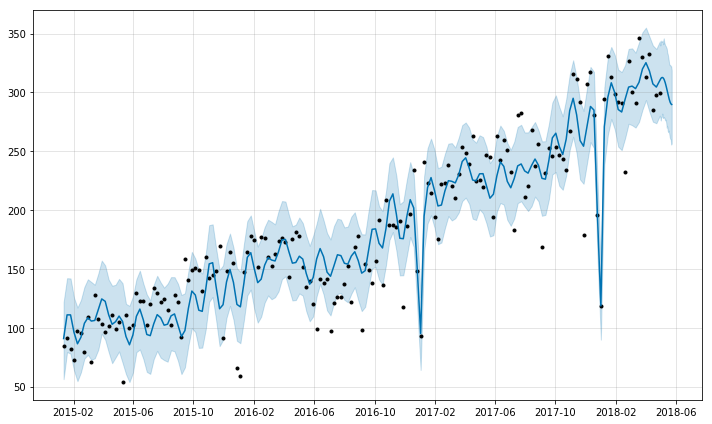

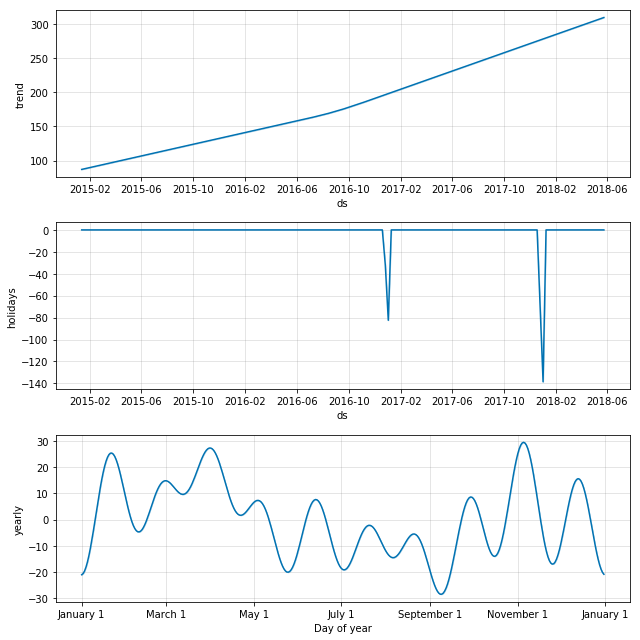

In [140]:
# Doctor's forecast + holidays
dr_model_h, dr_forecast_h, dr_pred_h = get_prophet_forecast_holidays_date_index(df=dr_df, date_col='AppointmentDate',\
        hours_col='Hours', pred_cols=pred_cols, periods=24, holidays=holidays1)


# plot forecast & decomposition w holidays
plot_prophet_forecast(dr_model_h, dr_forecast_h)

In [141]:
dr_pred_h

,ds,trend,trend_lower,trend_upper,yhat_lower,yhat_upper,Christams,Christams_lower,Christams_upper,New Years,...,seasonal,seasonal_lower,seasonal_upper,seasonalities,seasonalities_lower,seasonalities_upper,yearly,yearly_lower,yearly_upper,yhat
ds,,,,,,,,,,,,,,,,,,,,,
2018-05-01,2018-05-01,304.642805,304.642805,304.642805,278.811782,339.927717,0.0,0.0,0.0,0.0,...,6.409818,6.409818,6.409818,6.409818,6.409818,6.409818,6.409818,6.409818,6.409818,311.052624
2018-05-02,2018-05-02,304.862897,304.862897,304.862897,276.143362,344.073535,0.0,0.0,0.0,0.0,...,6.884564,6.884564,6.884564,6.884564,6.884564,6.884564,6.884564,6.884564,6.884564,311.747461
2018-05-03,2018-05-03,305.082988,305.082988,305.082988,279.245054,343.108431,0.0,0.0,0.0,0.0,...,7.196098,7.196098,7.196098,7.196098,7.196098,7.196098,7.196098,7.196098,7.196098,312.279087
2018-05-04,2018-05-04,305.303080,305.303080,305.303080,279.405951,343.455551,0.0,0.0,0.0,0.0,...,7.311712,7.311712,7.311712,7.311712,7.311712,7.311712,7.311712,7.311712,7.311712,312.614792
2018-05-05,2018-05-05,305.523172,305.523172,305.523172,282.046190,343.007827,0.0,0.0,0.0,0.0,...,7.204814,7.204814,7.204814,7.204814,7.204814,7.204814,7.204814,7.204814,7.204814,312.727985
2018-05-06,2018-05-06,305.743263,305.743263,305.743263,278.876620,344.203279,0.0,0.0,0.0,0.0,...,6.855852,6.855852,6.855852,6.855852,6.855852,6.855852,6.855852,6.855852,6.855852,312.599116
2018-05-07,2018-05-07,305.963355,305.963355,305.963355,278.219796,340.958345,0.0,0.0,0.0,0.0,...,6.253031,6.253031,6.253031,6.253031,6.253031,6.253031,6.253031,6.253031,6.253031,312.216386
2018-05-08,2018-05-08,306.183447,306.183447,306.183447,279.102056,345.983442,0.0,0.0,0.0,0.0,...,5.392787,5.392787,5.392787,5.392787,5.392787,5.392787,5.392787,5.392787,5.392787,311.576234
2018-05-09,2018-05-09,306.403538,306.403538,306.403538,278.602462,342.700892,0.0,0.0,0.0,0.0,...,4.280021,4.280021,4.280021,4.280021,4.280021,4.280021,4.280021,4.280021,4.280021,310.683559


In [ ]:
# add predicted number of providers column
dr_pred_h['Predicted_num_Providers'] = round(dr_pred_h['yhat'] / avg_dr_hours, 1)

#### previous work below

In [96]:
def get_prophet_forecast(df, df_name, df_cols, date_hours_cols, pred_cols, periods):
    """
    """
    df.columns = df_cols
    df = df[date_hours_cols]
    df.columns = ['ds', 'y']
    model = Prophet()
    model.fit(df)
    future = model.make_future_dataframe(periods=periods)
    forecast = model.predict(future)
    df_pred = pd.concat([df, forecast[pred_cols]], axis=1)
    predictions = forecast.iloc[-periods:]
    get_prophet_training_mse(df_pred, df_name, periods)
    get_prophet_test_mse(df_pred, df_name, periods)
    return model, forecast, df_pred

In [97]:
df_cols = ['date', 'Number_Providers', 'Hours', 'Hours_per_Provider']
date_hours_cols = ['date', 'Hours']
periods = 90
pred_cols = ['yhat', 'yhat_lower', 'yhat_upper']

In [98]:
avg_dr_hours = dr_df['Hours_per_Provider'].mean()

In [99]:
# get doctors forecast and save to csv file
dr_model, forecast, dr_pred = get_prophet_forecast(dr_df, 'Doctors', df_cols, date_hours_cols,\
                pred_cols, periods)

INFO:fbprophet.forecaster:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet.forecaster:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


MSE for Doctors training set is 746.6058243721752
MSE for Doctors test set is 851.8699555695715


In [71]:
dr_pred

,ds,y,yhat,yhat_lower,yhat_upper
0,2015-01-12,84.25,75.656539,42.112366,114.099295
1,2015-01-19,91.25,112.840963,75.989090,148.174472
2,2015-01-26,82.00,117.204014,81.956467,153.147304
3,2015-02-02,72.25,96.817200,63.037689,133.265669
4,2015-02-09,97.25,81.858919,47.026190,114.950298
5,2015-02-16,95.25,88.531973,56.391416,125.757274
6,2015-02-23,79.25,104.844164,70.343745,141.857407
7,2015-03-02,109.50,111.165665,76.612471,146.933657
8,2015-03-09,71.00,105.831960,71.092547,140.549205
9,2015-03-16,128.00,103.827385,69.226183,139.911734


In [ ]:
dr_pred['Predicted_num_Providers'] = round(dr_pred['yhat'] / avg_dr_hours, 1)

In [ ]:
dr_pred

In [ ]:
def prophet_forecast_to_csv(prediction_df, file_name):
    """Save prophet predictions in dataframe format to csv file"""
    prediction_df.columns = ['Date', 'True_Hours', 'Predicted_Hours', 'Lower_Limit', 'Upper_Limit', 'Predicted_num_Providers']
    prediction_df.to_csv('./data/{}_predictions.csv'.format(file_name))

In [ ]:
prophet_forecast_to_csv(dr_pred, 'doctors_prophet')

In [ ]:
# dr_forecast = pd.read_csv('./data/doctors_prophet_predictions.csv', index_col=0)

In [ ]:
# dr_forecast

In [ ]:
weekly_data = [dr_df, RNPA_df, ther_df]
df_names = ['Doctors', 'RN/PAs', 'therapists']

In [ ]:
# Get forecast and plot for all 3 categories
for i in range(len(weekly_data)):
    model, forecast, predictions_df = get_prophet_forecast(df=weekly_data[i], df_name=df_names[i], df_cols=df_cols,\
                     date_hours_cols=date_hours_cols, pred_cols=pred_cols, periods=periods)
    plot_prophet_forecast(model, forecast)

In [ ]:
# get MSE for forecasts with holidays w/ different windows included
holiday_windows = [holidays1, holidays2, holidays1_2, holidays2_1]
for i in range(len(weekly_data)):
    for h in holiday_windows:
        model, forecast, predictions_df = get_prophet_forecast_w_holidays(df=weekly_data[i], df_name=df_names[i], df_cols=df_cols,\
                     date_hours_cols=date_hours_cols, pred_cols=pred_cols, periods=periods, holidays=h)

In [ ]:
# Doctor's forecast + holidays
dr_model_h, dr_forecast_h, dr_pred_h = get_prophet_forecast_w_holidays(dr_df, 'Doctors', df_cols, date_hours_cols,\
                pred_cols, periods, holidays=h)
# plot forecast & decomposition w holidays
plot_prophet_forecast(dr_model_h, dr_forecast_h)

In [ ]:
# add predicted number of providers column
dr_pred_h['Predicted_num_Providers'] = round(dr_pred_h['yhat'] / avg_dr_hours, 1)

In [ ]:
# fig = plot_prophet_forecast(dr_model_h, dr_forecast_h, xlabel='Date', ylabel='Hours')
dr_fig = dr_model_h.plot(dr_forecast_h, xlabel='Date', ylabel='Hours')
dr_fig.savefig('./images/dr_prophet_model.png')

In [ ]:
dr_pred_h

In [ ]:
prophet_forecast_to_csv(dr_pred_h, 'doctors_prophet_holidays')

#### RN/PAs

In [ ]:
# RN/PA forecast + holidays
RNPA_model_h, RNPA_forecast_h, RNPA_pred_h = get_prophet_forecast_w_holidays(RNPA_df, 'RN/PAs', df_cols, date_hours_cols,\
                pred_cols, periods, holidays=h)
# plot forecast & decomposition w holidays
plot_prophet_forecast(RNPA_model_h, RNPA_forecast_h)

In [ ]:
# fig = plot_prophet_forecast(dr_model_h, dr_forecast_h, xlabel='Date', ylabel='Hours')
RNPA_fig = RNPA_model_h.plot(RNPA_forecast_h, xlabel='Date', ylabel='Hours')
RNPA_fig.savefig('./images/RNPA_prophet_model.png')

In [ ]:
avg_RNPA_hours = RNPA_df['Hours_per_Provider'].mean()

In [ ]:
# add predicted number of providers column
RNPA_pred_h['Predicted_num_Providers'] = round(RNPA_pred_h['yhat'] / avg_RNPA_hours, 1)

In [ ]:
prophet_forecast_to_csv(RNPA_pred_h, 'RNPA_prophet_holidays')

#### therapists

In [ ]:
# Therapists forecast + holidays
ther_model_h, ther_forecast_h, ther_pred_h = get_prophet_forecast_w_holidays(ther_df, 'Therapists', df_cols, date_hours_cols,\
                pred_cols, periods, holidays=h)
# plot forecast & decomposition w holidays
plot_prophet_forecast(ther_model_h, ther_forecast_h)

In [ ]:
# fig = plot_prophet_forecast(dr_model_h, dr_forecast_h, xlabel='Date', ylabel='Hours')
ther_fig = ther_model_h.plot(ther_forecast_h, xlabel='Date', ylabel='Hours')
ther_fig.savefig('./images/ther_prophet_model.png')

In [ ]:
avg_ther_hours = ther_df['Hours_per_Provider'].mean()

In [ ]:
# add predicted number of providers column
ther_pred_h['Predicted_num_Providers'] = round(ther_pred_h['yhat'] / avg_ther_hours, 1)

In [ ]:
prophet_forecast_to_csv(ther_pred_h, 'therapist_prophet_holidays')

In [ ]:
ther_pred_h

#### get 12 week forecasts

In [ ]:
forecasts = [dr_pred_h, RNPA_pred_h, ther_pred_h]

In [ ]:
dr_3mo_forecast = dr_pred_h[174:186]
RNPA_3mo_forecast = RNPA_pred_h[174:186]
ther_3mo_forecast = ther_pred_h[174:186]

In [ ]:
dr_3mo_forecast.columns

In [ ]:
# round predicted hours column
dr_3mo_forecast['Predicted_Hours'] = round(dr_3mo_forecast['Predicted_Hours'])

In [ ]:
dr_3mo_forecast

In [ ]:
dr_3mo_forecast =  dr_3mo_forecast[['Predicted_Hours', 'Predicted_num_Providers']]
dr_3mo_forecast.rename_axis('Week')

In [ ]:
# save df to image
dr_3mo_forecast.to_csv('./data/dr_12_week_prophet_forecast.csv')

#### get doctors 8-16 week forecast

In [ ]:
dr_8_to_16_wk_prophet = dr_pred_h[184:193]

In [ ]:
dr_8_to_16_wk_prophet

In [ ]:
# reset index to forecast week number
dr_8_to_16_wk_prophet = dr_8_to_16_wk_prophet.reset_index()

In [ ]:
dr_8_to_16_wk_prophet.index = dr_8_to_16_wk_prophet.index+8

In [ ]:
# round up hours column
dr_8_to_16_wk_prophet['Predicted_Hours'] = round(dr_8_to_16_wk_prophet['Predicted_Hours'],1)

In [ ]:
dr_8_to_16_wk_prophet =  dr_8_to_16_wk_prophet[['Predicted_Hours', 'Predicted_num_Providers']]
dr_8_to_16_wk_prophet.rename_axis('Week')

In [ ]:
# save df to image
dr_8_to_16_wk_prophet.to_csv('./data/dr_8_to_16_wk_prophet.csv')

#### save doctors predictions as images for presentation

In [ ]:
from pandas.tools.plotting import table
fig, ax = plt.subplots(figsize=(10,10)) # set size frame
ax.xaxis.set_visible(False)  # hide axes
ax.yaxis.set_visible(False)  
ax.set_frame_on(False)  
tabla = table(ax, dr_3mo_forecast, loc='center', colWidths=[0.3]*len(dr_3mo_forecast.columns))
tabla.auto_set_font_size(False) 
tabla.set_fontsize(16)
tabla.scale(1.5, 2) 
plt.savefig('./images/dr_12wk_Prophet_forecast.png', transparent=True)

In [ ]:
from pandas.tools.plotting import table
fig, ax = plt.subplots(figsize=(10,10)) # set size frame
ax.xaxis.set_visible(False)  # hide axes
ax.yaxis.set_visible(False)  
ax.set_frame_on(False)  
tabla = table(ax, dr_8_to_16_wk_prophet, loc='center', colWidths=[0.3]*len(dr_8_to_16_wk_prophet.columns))
tabla.auto_set_font_size(False) 
tabla.set_fontsize(16)
tabla.scale(1.5, 2) 
plt.savefig('./images/dr_8_to_16_wk_prophet.png', transparent=True)

#### Next Steps: 
##### add regressor for adding additional variable: number of providers

In [ ]:
# Potential next steps: add exogenous variable - number of providers to each model
# help(Prophet.add_regressor)